## Packages Needed to Run Script

In [9]:
#install.packages("data.table")
library(data.table)
#install.packages("curl")
library(curl)
#install.packages("dplyr")
library(dplyr)
#install.packages("ggplot2")
library(ggplot2)
#install.packages("pROC")
library(pROC)
#install.packages("caret")
library(caret)
#install.packages("xgboost")
library(xgboost)
#install.packages("reshape2")
library(reshape2)

Loading required package: lattice


## Cleaning data and putting in proper form for ggplot
-  I download the data from the website provided
-  Name all the columns based on the information provided
-  Create two new variables 'ClassName' and 'ClassBinary' based on being malignant or benign
-  Melting the data to use in ggplot and removing missing values

In [2]:
# Downloading data from website
dat <- fread("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data")
# Constructing column names
colnames(dat) <- c('id', 'ClumpThickness', 'CellSize', 'CellShape', 'MarginalAdhesion',
                   'EpithelialCellSize', 'BareNuclei', 'BlandChromatin', 'NormalNucleoli', 'Mitoses', 'Class')

# Making a named variable for 'benign' and 'malignant' and also a binary (0,1) variable for Class
dat <- dat %>% mutate('ClassName' = ifelse(Class == 2, 'benign', 'malignant'), 
                      'ClassBinary' = ifelse(Class == 2, 0, 1)) 

# Getting Data in the right form to plot all variables
# Notice that for some variables the value is '?' Therefore we have removed these
MeltDat <- melt(dat, id.vars = c('id', 'Class', 'ClassName', 'ClassBinary')) %>%
  filter(value != '?') %>% mutate(value = as.numeric(value))


## Summary Statistics of the nine variables

In [3]:
# Getting Summary statistics for all nine variables
SummaryDat <- MeltDat %>% group_by(variable, ClassName) %>% summarize(N = n(),Mean = mean(value), SD = sd(value),
                                                                      Median = median(value),
                                                                      Min = min(value), Max = max(value))


## Plotting the boxplots of the nine variables
-  We see that for the majority of the variables, there is a clear separation between the two groups. 
-  Therefore, we will create a mean variable of all the variables combined.

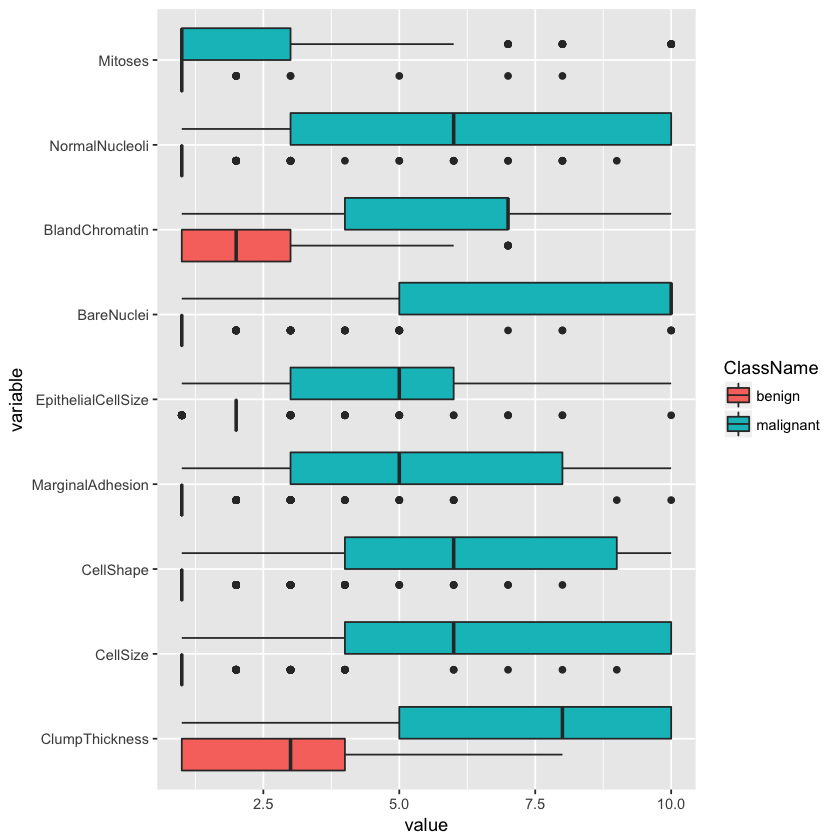

In [4]:
ggplot(MeltDat, aes(x = variable, y = value, fill = ClassName)) + geom_boxplot() + coord_flip() 


## Creating a feature based on the mean values of all nine variables
-  This is valid because all the variables range from 1-10 
-  If this was not the case we could normalize and then generate the mean from the normaized values
-  I join the 'OverallMean' variable back to the original dataset

In [5]:
OverallMean <- MeltDat %>% group_by(id, ClassName) %>% summarize(OverallMean = mean(value))
dat <- dat %>% left_join(OverallMean, by = 'id') %>% dplyr::select(ClumpThickness, MarginalAdhesion,
                                                                      BareNuclei, BlandChromatin, OverallMean,
                                                                    ClassBinary)%>% filter(BareNuclei != '?') %>% 
  mutate(BareNuclei = as.numeric(BareNuclei))


## Plotting the densities of the new variable 'OverallMean'
-  You can see a clear separation between the two groups 

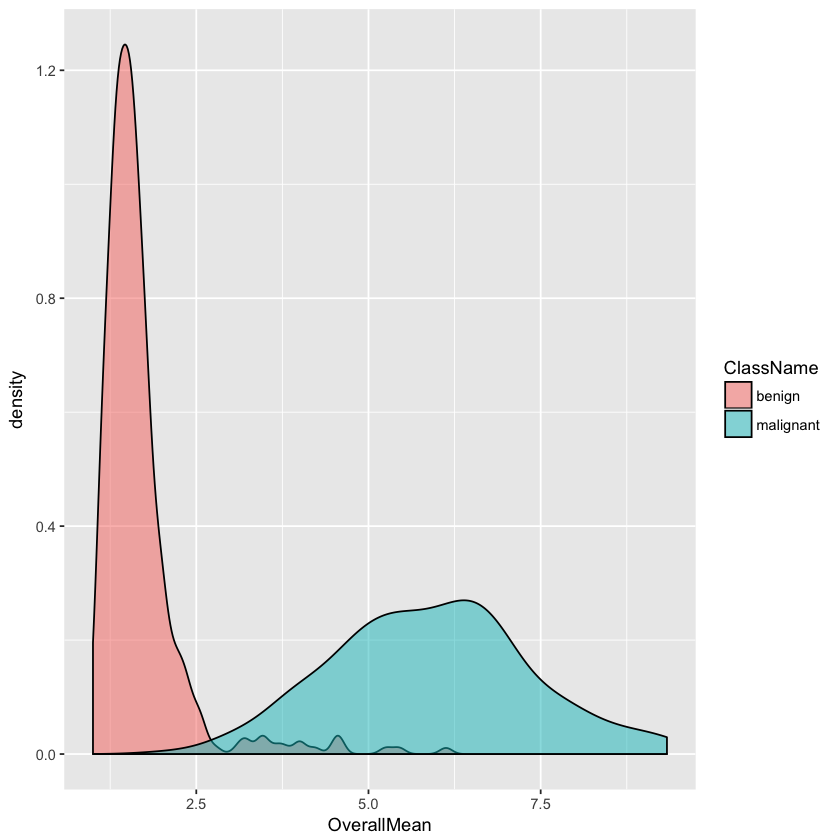

In [6]:
ggplot(OverallMean, aes(x = OverallMean, group = ClassName, fill = ClassName)) + geom_density(alpha = 0.5)

## CrossValidation Function
-  Here I have set up a k-fold crossvalidation function for a logistic and XGBoost model
-  The comparison metric here is the accuracy but can easily be changed to something different
-  The accuracy of the two models are returned and the ROC curve for each of the folds
-  The user will need to supply:
    -  The data being used (Dat)
    -  The variables being used in the models (vars)
    -  What the Outcome variable is (Outcome)
    -  The family used for the distribution of the data (Family)
    -  The Metric for evaluation in the XGBoost model (Metric)
    -  Number of Folds wanting to be used (NumFolds)

In [7]:
CrossFunction <- function(Dat, vars, Outcome, Family, Metric, NumFolds){
Predictions <- list()
for(i in 1: NumFolds){
  OutcomeVar <- Dat[,Outcome]
  Folds <- createFolds(OutcomeVar, k = 5, 
                       list = TRUE, 
                       returnTrain = FALSE)
  
  ModelDat <- Dat %>% dplyr::select(one_of(vars), one_of(Outcome))
  
  ### Train and Test data 
  TrainDat <- ModelDat[-Folds[[i]], ]
  TestDat  <- ModelDat[Folds[[i]], ]
  
  
  ### Linear Model
  LMMod <- glm(ClassBinary ~ . , data = TrainDat,
               family = Family)
  
  
  ######################## XGBoost Model ###########################
  ## Data needs to be characterized a little different to use XGBoost
  
  ### Train data in the format needed for xgboost
  XGTrainDat <- TrainDat %>% dplyr::select(one_of(vars))
  XGTrain <- model.matrix(~. -1, data = XGTrainDat, sparse = TRUE)
  
  ###### The Outcome of the trained model
  OutcomeTrain <- TrainDat[,Outcome]
  
  ### XGBoost model
  ## Note that I have already run a analysis to check parameter values in XGBoost
  bst2 <- xgboost(data = XGTrain, label = OutcomeTrain, max_depth = 3,
                   objective = 'binary:logistic',
                  eta = .1, nthread = 2, nrounds = 100)
  
  ###################### Predicting the test data #########################
  XGTestDat <- TestDat %>% dplyr::select(one_of(vars))
  XGTest <- model.matrix(~. -1, data = XGTestDat, sparse = TRUE)
  
  
  ### The predicted values for the test data for each  of the four models
  LMPred  <- predict(LMMod,newdata = TestDat,type = 'response')
  XGPred  <- predict(bst2, XGTest)
  ### Actual Prices
  TestOutcome <- TestDat[,Outcome]
  
  roc1 <- pROC::roc(response = TestOutcome, predictor = LMPred, levels=c(0, 1))
  roc2 <- pROC::roc(response = TestOutcome, predictor = XGPred, levels=c(0, 1))
  print(ggroc(list(roc1, roc2)))
 
  ### Creating a dataframe of the models and the predicted prices
  AllPred <- data.frame(TestOutcome, LMPred, XGPred) %>%
    mutate('LMCorrect' = ifelse((LMPred >= .5 & TestOutcome == 1 ) | (LMPred < .5 & TestOutcome == 0 ), 1, 0),
           'XGCorrect' = ifelse((XGPred >= .5 & TestOutcome == 1 ) | (XGPred < .5 & TestOutcome == 0 ), 1, 0))
  FoldAnswer <- c('CorrectLM' = mean(AllPred$LMCorrect), 'CorrectXG' = mean(AllPred$XGCorrect))
  
  Predictions[[i]] <- FoldAnswer
}

return(Predictions )
}


## Running Crossvalidation
-  I supply the data created above (dat)
-  The final variable(s) used in my final model
    -  Note that I only use the 'OverallMean' variable because this supplies enough information to get extremely high accuracy
    -  Adding some of the other significant variables did improve very slightly, however I did not see any reason to add these for such a small improvement
-  The family and outcome variable
-  Lastly, I used 5 fold crossvalidation
-  From all of these results I see that there is not much a difference between the logistic regression results and the XGboost results, thus I would choose the simpler of the two, the logistic regression model.

[1]	train-error:0.032550 
[2]	train-error:0.032550 
[3]	train-error:0.032550 
[4]	train-error:0.032550 
[5]	train-error:0.032550 
[6]	train-error:0.032550 
[7]	train-error:0.032550 
[8]	train-error:0.032550 
[9]	train-error:0.032550 
[10]	train-error:0.032550 
[11]	train-error:0.032550 
[12]	train-error:0.032550 
[13]	train-error:0.032550 
[14]	train-error:0.032550 
[15]	train-error:0.032550 
[16]	train-error:0.032550 
[17]	train-error:0.032550 
[18]	train-error:0.032550 
[19]	train-error:0.032550 
[20]	train-error:0.032550 
[21]	train-error:0.032550 
[22]	train-error:0.032550 
[23]	train-error:0.032550 
[24]	train-error:0.032550 
[25]	train-error:0.032550 
[26]	train-error:0.032550 
[27]	train-error:0.032550 
[28]	train-error:0.032550 
[29]	train-error:0.032550 
[30]	train-error:0.032550 
[31]	train-error:0.032550 
[32]	train-error:0.032550 
[33]	train-error:0.032550 
[34]	train-error:0.032550 
[35]	train-error:0.032550 
[36]	train-error:0.032550 
[37]	train-error:0.032550 
[38]	train

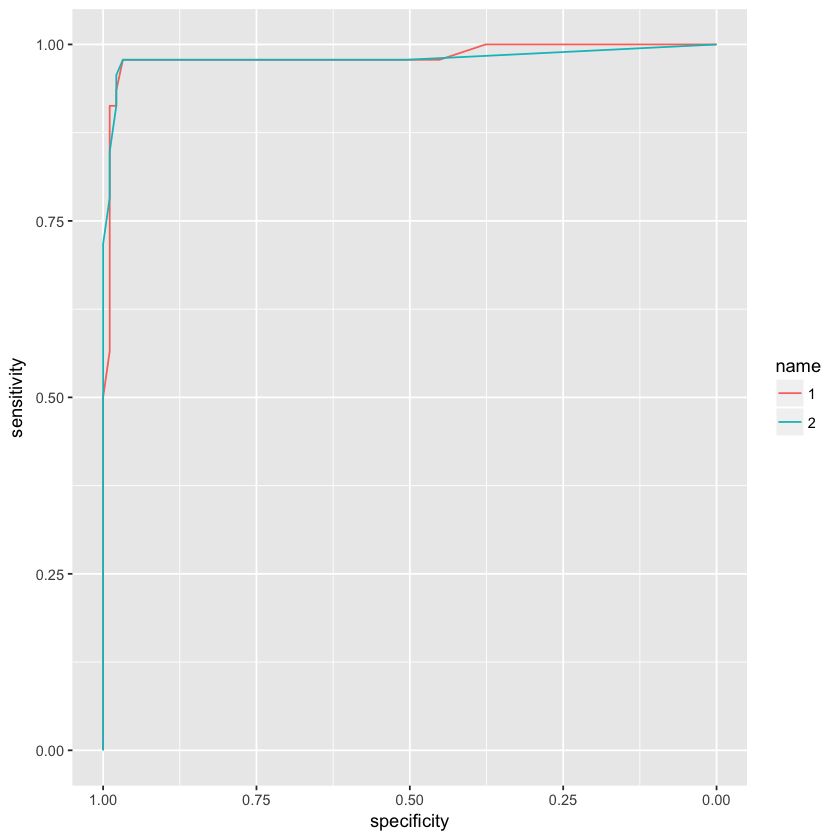

[1]	train-error:0.039711 
[2]	train-error:0.039711 
[3]	train-error:0.039711 
[4]	train-error:0.039711 
[5]	train-error:0.039711 
[6]	train-error:0.039711 
[7]	train-error:0.032491 
[8]	train-error:0.032491 
[9]	train-error:0.032491 
[10]	train-error:0.032491 
[11]	train-error:0.032491 
[12]	train-error:0.032491 
[13]	train-error:0.032491 
[14]	train-error:0.032491 
[15]	train-error:0.032491 
[16]	train-error:0.032491 
[17]	train-error:0.032491 
[18]	train-error:0.032491 
[19]	train-error:0.032491 
[20]	train-error:0.032491 
[21]	train-error:0.032491 
[22]	train-error:0.032491 
[23]	train-error:0.032491 
[24]	train-error:0.032491 
[25]	train-error:0.032491 
[26]	train-error:0.032491 
[27]	train-error:0.032491 
[28]	train-error:0.032491 
[29]	train-error:0.032491 
[30]	train-error:0.032491 
[31]	train-error:0.032491 
[32]	train-error:0.032491 
[33]	train-error:0.032491 
[34]	train-error:0.032491 
[35]	train-error:0.032491 
[36]	train-error:0.032491 
[37]	train-error:0.032491 
[38]	train

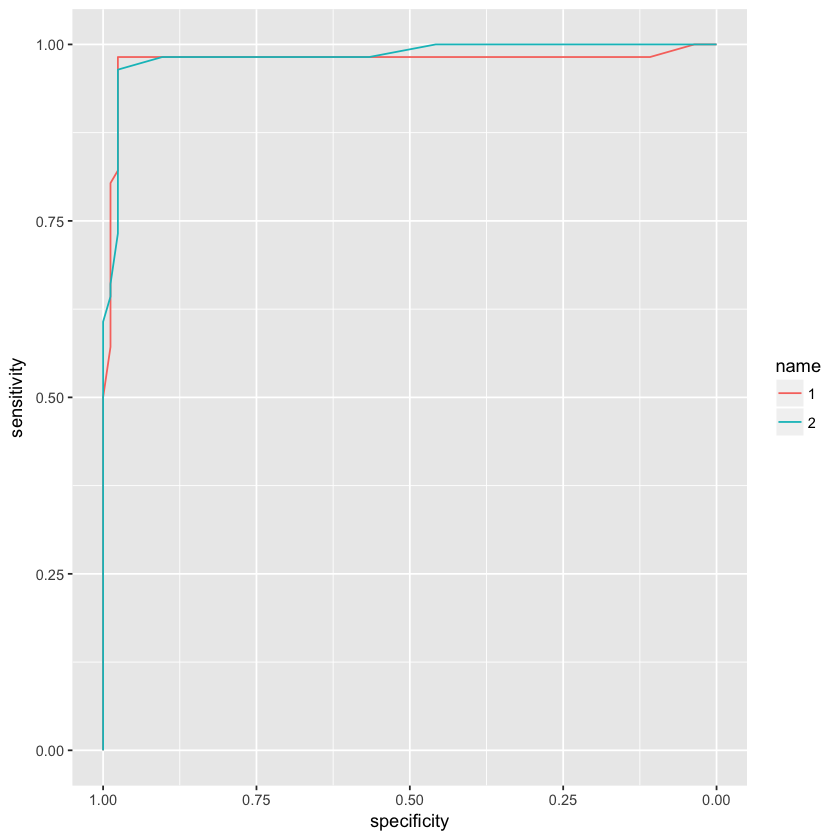

[1]	train-error:0.034296 
[2]	train-error:0.034296 
[3]	train-error:0.034296 
[4]	train-error:0.034296 
[5]	train-error:0.034296 
[6]	train-error:0.034296 
[7]	train-error:0.034296 
[8]	train-error:0.034296 
[9]	train-error:0.034296 
[10]	train-error:0.034296 
[11]	train-error:0.034296 
[12]	train-error:0.034296 
[13]	train-error:0.034296 
[14]	train-error:0.034296 
[15]	train-error:0.034296 
[16]	train-error:0.034296 
[17]	train-error:0.034296 
[18]	train-error:0.034296 
[19]	train-error:0.034296 
[20]	train-error:0.034296 
[21]	train-error:0.034296 
[22]	train-error:0.034296 
[23]	train-error:0.034296 
[24]	train-error:0.034296 
[25]	train-error:0.034296 
[26]	train-error:0.034296 
[27]	train-error:0.034296 
[28]	train-error:0.034296 
[29]	train-error:0.034296 
[30]	train-error:0.034296 
[31]	train-error:0.034296 
[32]	train-error:0.034296 
[33]	train-error:0.034296 
[34]	train-error:0.034296 
[35]	train-error:0.034296 
[36]	train-error:0.034296 
[37]	train-error:0.034296 
[38]	train

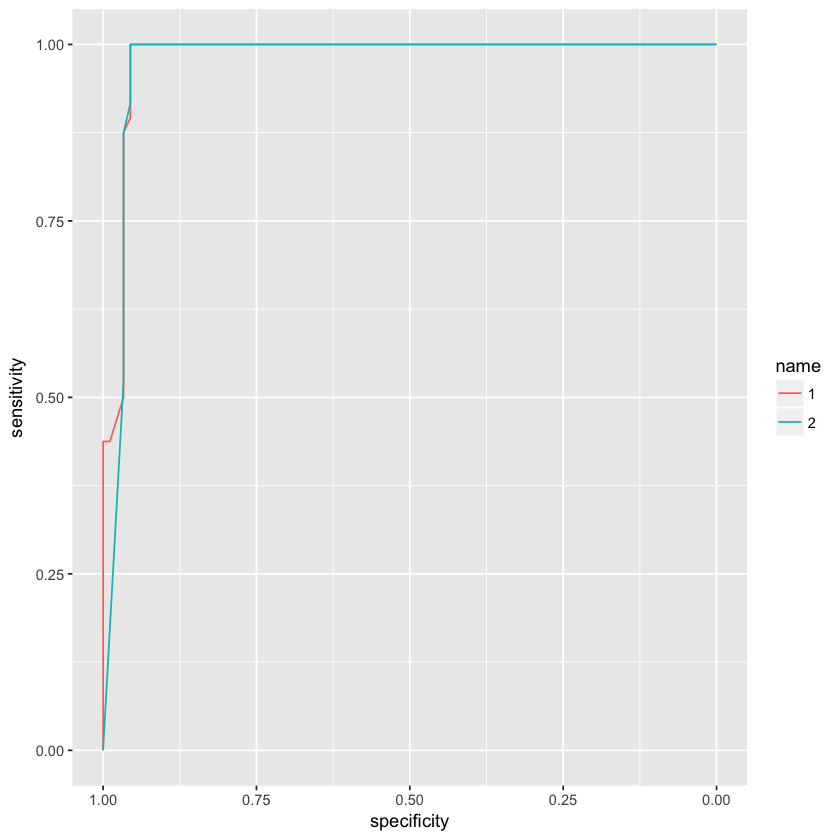

[1]	train-error:0.030686 
[2]	train-error:0.030686 
[3]	train-error:0.030686 
[4]	train-error:0.032491 
[5]	train-error:0.032491 
[6]	train-error:0.032491 
[7]	train-error:0.032491 
[8]	train-error:0.032491 
[9]	train-error:0.032491 
[10]	train-error:0.032491 
[11]	train-error:0.032491 
[12]	train-error:0.032491 
[13]	train-error:0.032491 
[14]	train-error:0.032491 
[15]	train-error:0.032491 
[16]	train-error:0.032491 
[17]	train-error:0.032491 
[18]	train-error:0.032491 
[19]	train-error:0.032491 
[20]	train-error:0.032491 
[21]	train-error:0.032491 
[22]	train-error:0.032491 
[23]	train-error:0.032491 
[24]	train-error:0.032491 
[25]	train-error:0.032491 
[26]	train-error:0.032491 
[27]	train-error:0.032491 
[28]	train-error:0.032491 
[29]	train-error:0.032491 
[30]	train-error:0.032491 
[31]	train-error:0.032491 
[32]	train-error:0.032491 
[33]	train-error:0.032491 
[34]	train-error:0.032491 
[35]	train-error:0.032491 
[36]	train-error:0.032491 
[37]	train-error:0.032491 
[38]	train

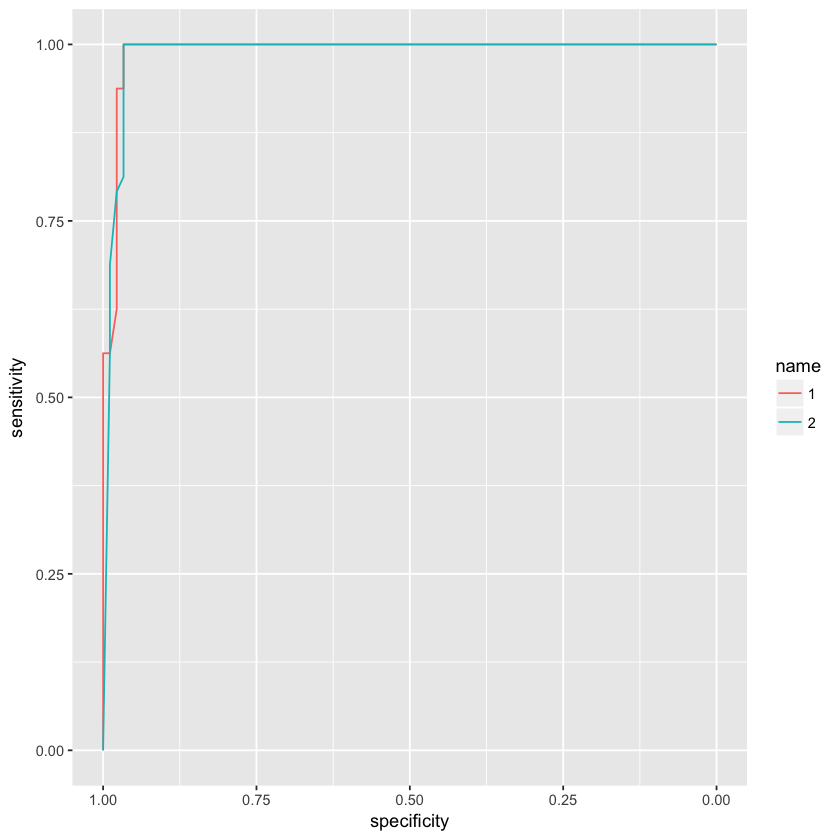

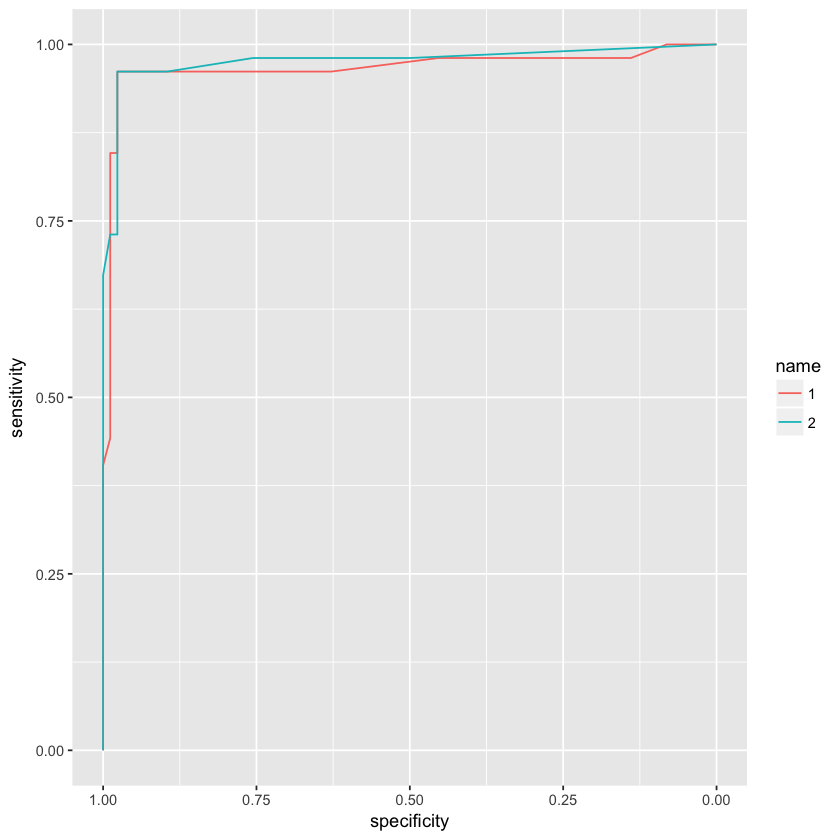

In [10]:
Test <- CrossFunction(Dat = dat, vars =c('OverallMean') , 
              Outcome = 'ClassBinary' , Family = 'binomial', NumFolds = 5)


In [11]:
Test

[[1]]
CorrectLM CorrectXG 
 0.971223  0.971223 

[[2]]
CorrectLM CorrectXG 
0.9424460 0.9496403 

[[3]]
CorrectLM CorrectXG 
0.9710145 0.9637681 

[[4]]
CorrectLM CorrectXG 
0.9565217 0.9782609 

[[5]]
CorrectLM CorrectXG 
0.9420290 0.9347826

## Final Thoughts and Considerations
-  Extremely unbalanced data can be a huge issue when modeling, however in this particular situation we do not see too unbalanaced of a dataset to be concerned (35% vs. 65%). If this was the case, we would need to balance the data by maybe doing a boostrapping technique selecting random sample of the large group and comparing to the smaller group.
-  Further, The variable that was used did not appear to be skewed to the right for us to need to consider a transformation such as a Box-Cox for the model performance to increase.
-  I did not show my variable selection here, however I did use a stepwise procedure because our sample size was not too large and we did not have too many variables to feel the need to do PCA, LASSO, etc. Also, we saw that we could capture the bulk of the distinctions by creating a mean of all nine variables and only using this in the model.
-  A more complex model may be considered if there wasn't already a more clear distinction between the two groups.
-  Feature enginerring is extremely important and can give you more insight to the two groups that you may not be able to see from the actual data, however this was not the case in this particular situation.
-  XGBoost is an extremely powerful tool, but it is much harder to tune and optimize than the logistic regression. Thus, I selected the logistic model here because its performance was almost identical to that of the XGBoost model.